# The 3 Body Problem: 1st Assignment

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV

import time # Check later what this does

# Task 1.1: Pre processing of Data and Validation Pipeline

In [2]:
data = pd.read_csv(r'C:\Users\Edgar\OneDrive - FCT NOVA\Desktop\Aprendizagem Automática\Assignments\Assignment 1\mlNOVA\mlNOVA/X_train.csv',
    sep = ",", decimal = ".", 
    names = ["t","x_1","y_1","v_x_1","y_v_1","x_2","y_2","v_x_2","v_y_2","x_3","y_3","v_x_3","v_y_3","id"],
    header = 0)

#data.describe()
#data.isnull().sum()


From teacher's video, collisions happen so I need to drop rows where the whole row is
full of zeros, cause they are meaningless:

In [3]:
new_data = data.drop(columns = ['v_x_1', 'y_v_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3', 'id'])

collisions = new_data[(new_data[['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']] == 0).all(axis=1)]
new_data = new_data.drop(collisions.index)
new_data = new_data.reset_index(drop=True)

#new_data.describe()
#new_data.isnull().sum()

#new_data[514:530]
#data.describe()
#data.isnull().sum()


In [5]:
def Matrix_X(data):
    
    # Initialize an empty list to store the new matrix
    new_matrix = []

    # Get the unique index positions where t = 0 (starting points of each cycle)
    zero_t_indices = data[data['t'] == 0].index

    # Loop over each cycle
    for idx, start_idx in enumerate(zero_t_indices):
        # Set the end of the current cycle
        if idx < len(zero_t_indices) - 1:
            end_idx = zero_t_indices[idx + 1]
        else:
            end_idx = len(data)  # If it's the last cycle, go to the end of the dataframe

        # Ensure start_idx and end_idx are valid and in the correct order
        if end_idx <= start_idx:
            raise ValueError(f"Invalid cycle range: start_idx={start_idx}, end_idx={end_idx}")

        # Extract the reference row where t = 0 for the current cycle
        reference_row = data.loc[start_idx].copy()

        # For each row in the current cycle, replicate the reference row but keep the original 't' value
        for i in range(start_idx, end_idx):
            # Copy the reference row and assign the correct t value
            new_row = reference_row.copy()
            new_row['t'] = data.loc[i, 't']  # Keep the original t value
            new_matrix.append(new_row.values)

    # Convert the list of arrays into a single 2D array (matrix)
    new_matrix = np.vstack(new_matrix)

    # Create a new DataFrame to hold the transformed data
    new_df = pd.DataFrame(new_matrix, columns=data.columns)

    return new_df
    
matrix_X = Matrix_X(new_data)
print('Matrix X:')
matrix_X['t'][:257]

Matrix X:


0       0.000000
1       0.039062
2       0.078125
3       0.117188
4       0.156250
         ...    
252     9.843750
253     9.882810
254     9.921880
255     9.960940
256    10.000000
Name: t, Length: 257, dtype: float64

In [6]:
data_Y = data.drop(columns = ['v_x_1', 'y_v_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3', 'id', 't'])
data_Y

collisions = data_Y[(data_Y[[ 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']] == 0).all(axis=1)]
data_Y = data_Y.drop(collisions.index)
matrix_Y = data_Y.reset_index(drop=True)
print('Matrix Y:')
matrix_Y

Matrix Y:


,x_1,y_1,x_2,y_2,x_3,y_3
0,1.000000,0.000000,-0.266467,0.859196,-0.733533,-0.859196
1,0.999548,0.000092,-0.266261,0.858781,-0.733287,-0.858874
2,0.998190,0.000370,-0.265641,0.857535,-0.732549,-0.857905
3,0.995925,0.000833,-0.264606,0.855456,-0.731318,-0.856289
4,0.992747,0.001483,-0.263154,0.852540,-0.729592,-0.854022
...,...,...,...,...,...,...
1089785,-0.022787,-0.354678,-0.128897,-0.618452,0.151684,0.973131
1089786,-0.082072,-0.384254,-0.084507,-0.627569,0.166578,1.011822
1089787,-0.140434,-0.438907,-0.040823,-0.610311,0.181257,1.049218
1089788,-0.177344,-0.524277,-0.018380,-0.561151,0.195724,1.085428


# Spliting the Data into Train, Val and Test sets:

To avoid leakage, we must firstly split the data into matrix X an Y by creating batches of trajectories:

In [7]:
def split_into_batches(dataX, dataY): #Reformulate this code later
    "Splits the dataset into batches where each batch represents one trajectory of the bodies"
    batches_X = []
    batches_Y = []
    new_batch_X = []
    new_batch_Y = []
    
    for i in range(len(dataX)):
        row_X = dataX.iloc[i]
        row_Y = dataY.iloc[i]
        new_batch_X.append(row_X)
        new_batch_Y.append(row_Y)
        if row_X['t'] == 10:
            batches_X.append(pd.DataFrame(new_batch_X))
            batches_Y.append(pd.DataFrame(new_batch_Y))
            new_batch_X = []
            new_batch_Y = []
            
    if new_batch_X:
        batches_X.append(pd.DataFrame(new_batch_X))
        batches_Y.append(pd.DataFrame(new_batch_Y))
        
    return batches_X, batches_Y        

X, Y = split_into_batches(matrix_X, matrix_Y)
#X
#Y

Just now notice that some batches of trajectories have more than 257 rows (from 0 to 256), so it is necessary to remove
the excessive rows:

In [8]:
def remove_excessive_rows(datasetX, datasetY, cycle_value=257):
    X = []
    Y = []
    reference_t_values = datasetX[0]['t'][:cycle_value]  # Use the 't' values from the first dataframe (257 rows)
    
    for trajX, trajY in zip(datasetX, datasetY):
        if len(trajX) > 257:
            # Reset the index for both DataFrames
            trajX_reset = trajX.reset_index(drop=True)
            trajY_reset = trajY.reset_index(drop=True)
            
            # Keep only rows where 't' values match the reference
            matching_t_X = trajX_reset[trajX_reset['t'].isin(reference_t_values)]
            
            # Use the index of the filtered `matching_t_X` to filter `trajY_reset`
            matching_t_Y = trajY_reset.iloc[matching_t_X.index]

            # Select up to the specified number of rows
            matching_t_X = matching_t_X.iloc[:cycle_value]
            matching_t_Y = matching_t_Y.iloc[:cycle_value]
                
            X.append(matching_t_X)
            Y.append(matching_t_Y)
        else:
            X.append(trajX)
            Y.append(trajY)

    return X, Y

X, Y = remove_excessive_rows(X, Y)

#total_rows = sum([len(df) for df in Y])
#print(f"Total number of rows in Y: {total_rows}")

#print(len(X))   # Should show the number of rows
#print([len(x) for x in X])  # Check the length of each row

def list_to_dataframe(df_list):
    # Use pd.concat to combine the list of DataFrames into one DataFrame
    return pd.concat(df_list, axis=0).reset_index(drop=True)

# Convert list of DataFrames X and Y into single DataFrames
X_df = list_to_dataframe(X)  # X is now a single DataFrame
Y_df = list_to_dataframe(Y)  # Y is now a single DataFrame

#X_df

Finally spliting into Train, Val and Test (don't forget that you need to split taking into account
that samples from same trajectory need to be in only one set to avoid leakage, according to teacher- see why later;
in slides it is mentioned that 0.3% is enough to test 1M)

In [12]:
#Spliting the data with the following distribution: 95% train, 2.5% val, 2.5% test
X_main, X_test, Y_main, Y_test = train_test_split(X_df, Y_df, test_size=0.05, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(X_main, Y_main, test_size=0.5, shuffle=False)
#X_train.shape
#X_val.shape
#X_test.shape

Perform a shuffle within each set:

In [13]:
Shuffled_X_train = X_train.sample(frac = 1, random_state = 42).reset_index(drop=True) # why = 42? see later
Shuffled_X_val = X_val.sample(frac = 1, random_state = 42).reset_index(drop=True)
Shuffled_X_test = X_test.sample(frac = 1, random_state = 42).reset_index(drop=True)
Shuffled_Y_train = Y_train.sample(frac = 1, random_state = 42).reset_index(drop=True)
Shuffled_Y_val = Y_val.sample(frac = 1, random_state = 42).reset_index(drop=True)
Shuffled_Y_test = Y_test.sample(frac = 1, random_state = 42).reset_index(drop=True)

# Task 1.2 Learning the baseline model

In [14]:
# Don't exactly understand I are we using this here since we already have build a X_test
# Difference between X_test_buil and X_test_kaggle (ask prof later) ?
X_test_kaggle = pd.read_csv(r'C:\Users\Edgar\OneDrive - FCT NOVA\Desktop\Aprendizagem Automática\Assignments\Assignment 1\mlNOVA\mlNOVA\X_test.csv', 
            sep = ",", decimal = ".", 
            names = ["id","t","x0_1", "y0_1", "x0_2", "y0_2", "x0_3", "y0_3"],
            header = 0)

In [21]:
# Strange error, don't know de meaning - need to convert the DataFrames into Numpy arrays (don't understand why, search more later):
X_train_array = Shuffled_X_train.to_numpy()
X_val_array = Shuffled_X_val.to_numpy()
X_test_array = Shuffled_X_test.to_numpy()
Y_train_array = Shuffled_Y_train.to_numpy()
Y_val_array = Shuffled_Y_val.to_numpy()
Y_test_array = Shuffled_Y_test.to_numpy()

In [22]:
#Search later what is the difference between make_pipeline and Pipeline - for now use make_pipeline
pipeline = make_pipeline(StandardScaler(), LinearRegression())

#Training the model
pipeline.fit(X_train_array, Y_train_array)

yhat_val = pipeline.predict(X_val_array)

#y_hat_test = pipeline.predict(Shuffled_X_test)


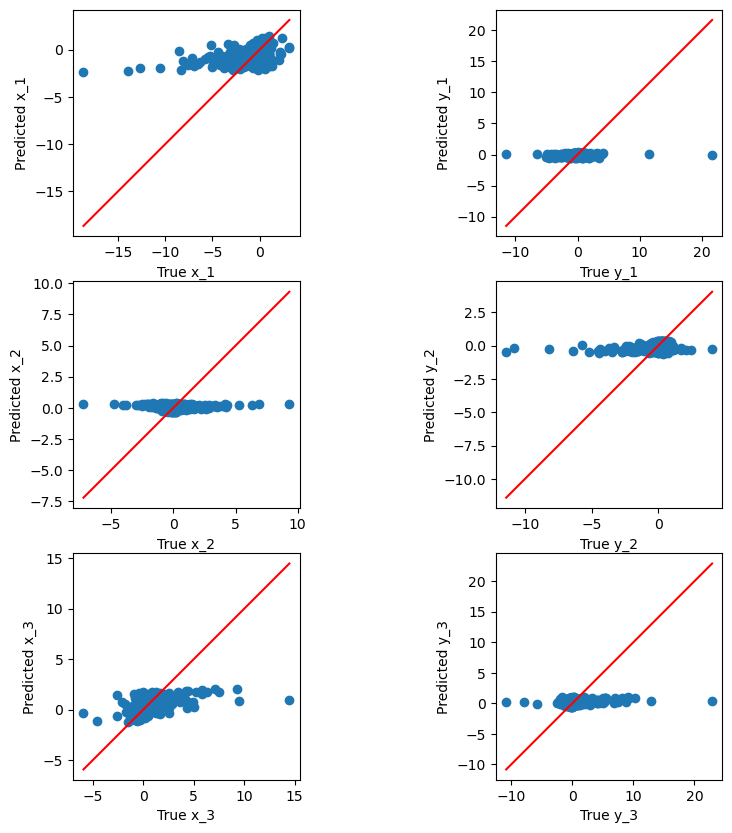

rmse: 0.7655541636086755


In [31]:
# Using provided function by teacher (comparing y and y_hat)
def plot_y_yhat(y_val,y_pred, plot_title = "plot Linear Regression "):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_val) > MAX:
        idx = np.random.choice(len(y_val),MAX, replace=False)
    else:
        idx = np.arange(len(y_val))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_val[idx,i])
        x1 = np.max(y_val[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_val[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig(plot_title+'baseline.jpeg', dpi = 300)
    plt.show()

plot_y_yhat(Y_val_array, yhat_val)

# mse
rmse = np.mean(np.sqrt((Shuffled_Y_val - yhat_val)**2))
print('rmse:', rmse)


In [ ]:
#comparing with kaggle data

yhat_val_kaggle = pipeline.predict(X_test_kaggle) 

def plot_y_yhat(y_val,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_val) > MAX:
        idx = np.random.choice(len(y_val),MAX, replace=False)
    else:
        idx = np.arange(len(y_val))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_val[idx,i])
        x1 = np.max(y_val[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_val[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig(plot_title+'baseline.jpeg', dpi = 300)
    plt.show()

plot_y_yhat(Y_val_array, )

# mse
mse = np.mean((y - y_hat)**2)
print('mse:', mse)

# Task 2: Nonlinear models on the data — the Polynomial Regression model

# 2.1 Development:

In [49]:
def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,15), max_features=None):
    best_degree = None
    best_rmse = float('inf')
    best_model = None
    selected_degrees = []

    for _ in range(n_trials):
        # Sample 1% of the training data
        X_sample, y_sample = resample(X_train, y_train, n_samples=int(0.01 * len(X_train)), random_state=None)
        
        degree_rmses = []
        
        for degree in degrees:
            # Set up the pipeline for polynomial feature transformation and regression
            polynomial_features = PolynomialFeatures(degree=degree)
            model = regressor if regressor else LinearRegression()

            pipeline = Pipeline([
                ("poly_features", polynomial_features),
                ("regressor", model)
            ])

            # Fit the model
            pipeline.fit(X_sample, y_sample)

            # Check the number of features generated by PolynomialFeatures
            n_output_features = pipeline.named_steps["poly_features"].n_output_features_
            print(f"Degree {degree} generated {n_output_features} features")

            # Predict and calculate RMSE on validation set
            y_val_pred = pipeline.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
            degree_rmses.append((degree, rmse))

            # Keep track of the best model and degree
            if rmse < best_rmse:
                best_rmse = rmse
                best_degree = degree
                best_model = pipeline
        
        # Append the best degree from this trial
        selected_degrees.append(best_degree)

    # Plot the distribution of selected degrees across trials
    plt.hist(selected_degrees, bins=len(degrees), edgecolor='black')
    plt.title("Distribution of Selected Polynomial Degrees")
    plt.xlabel("Polynomial Degree")
    plt.ylabel("Frequency")
    plt.show()

    return best_model, best_rmse, selected_degrees
        

validate_poly_regression(X_train_array, Y_train_array_X)

NameError: name 'resample' is not defined

# Task 2.2 Evaluation

# Task 3. Feature Engineering

3.1 Development: "Explore the features and verify if there are any linear relationships between them. 
Remember, features should be uncorrelated with each other and highly correlated with the target variables. Use the Seaborn package to inspect these relationships."

- Sort the interactions by the absolute value of the correlations.
- Eliminate the more redundant variables one by one, and check the impact of eliminating each variable on the baseline model performance using RMSE and y-y hat plots.
- Select some of the experiments, add the plots to the slides, and use them to justify your choices for eliminating variables.

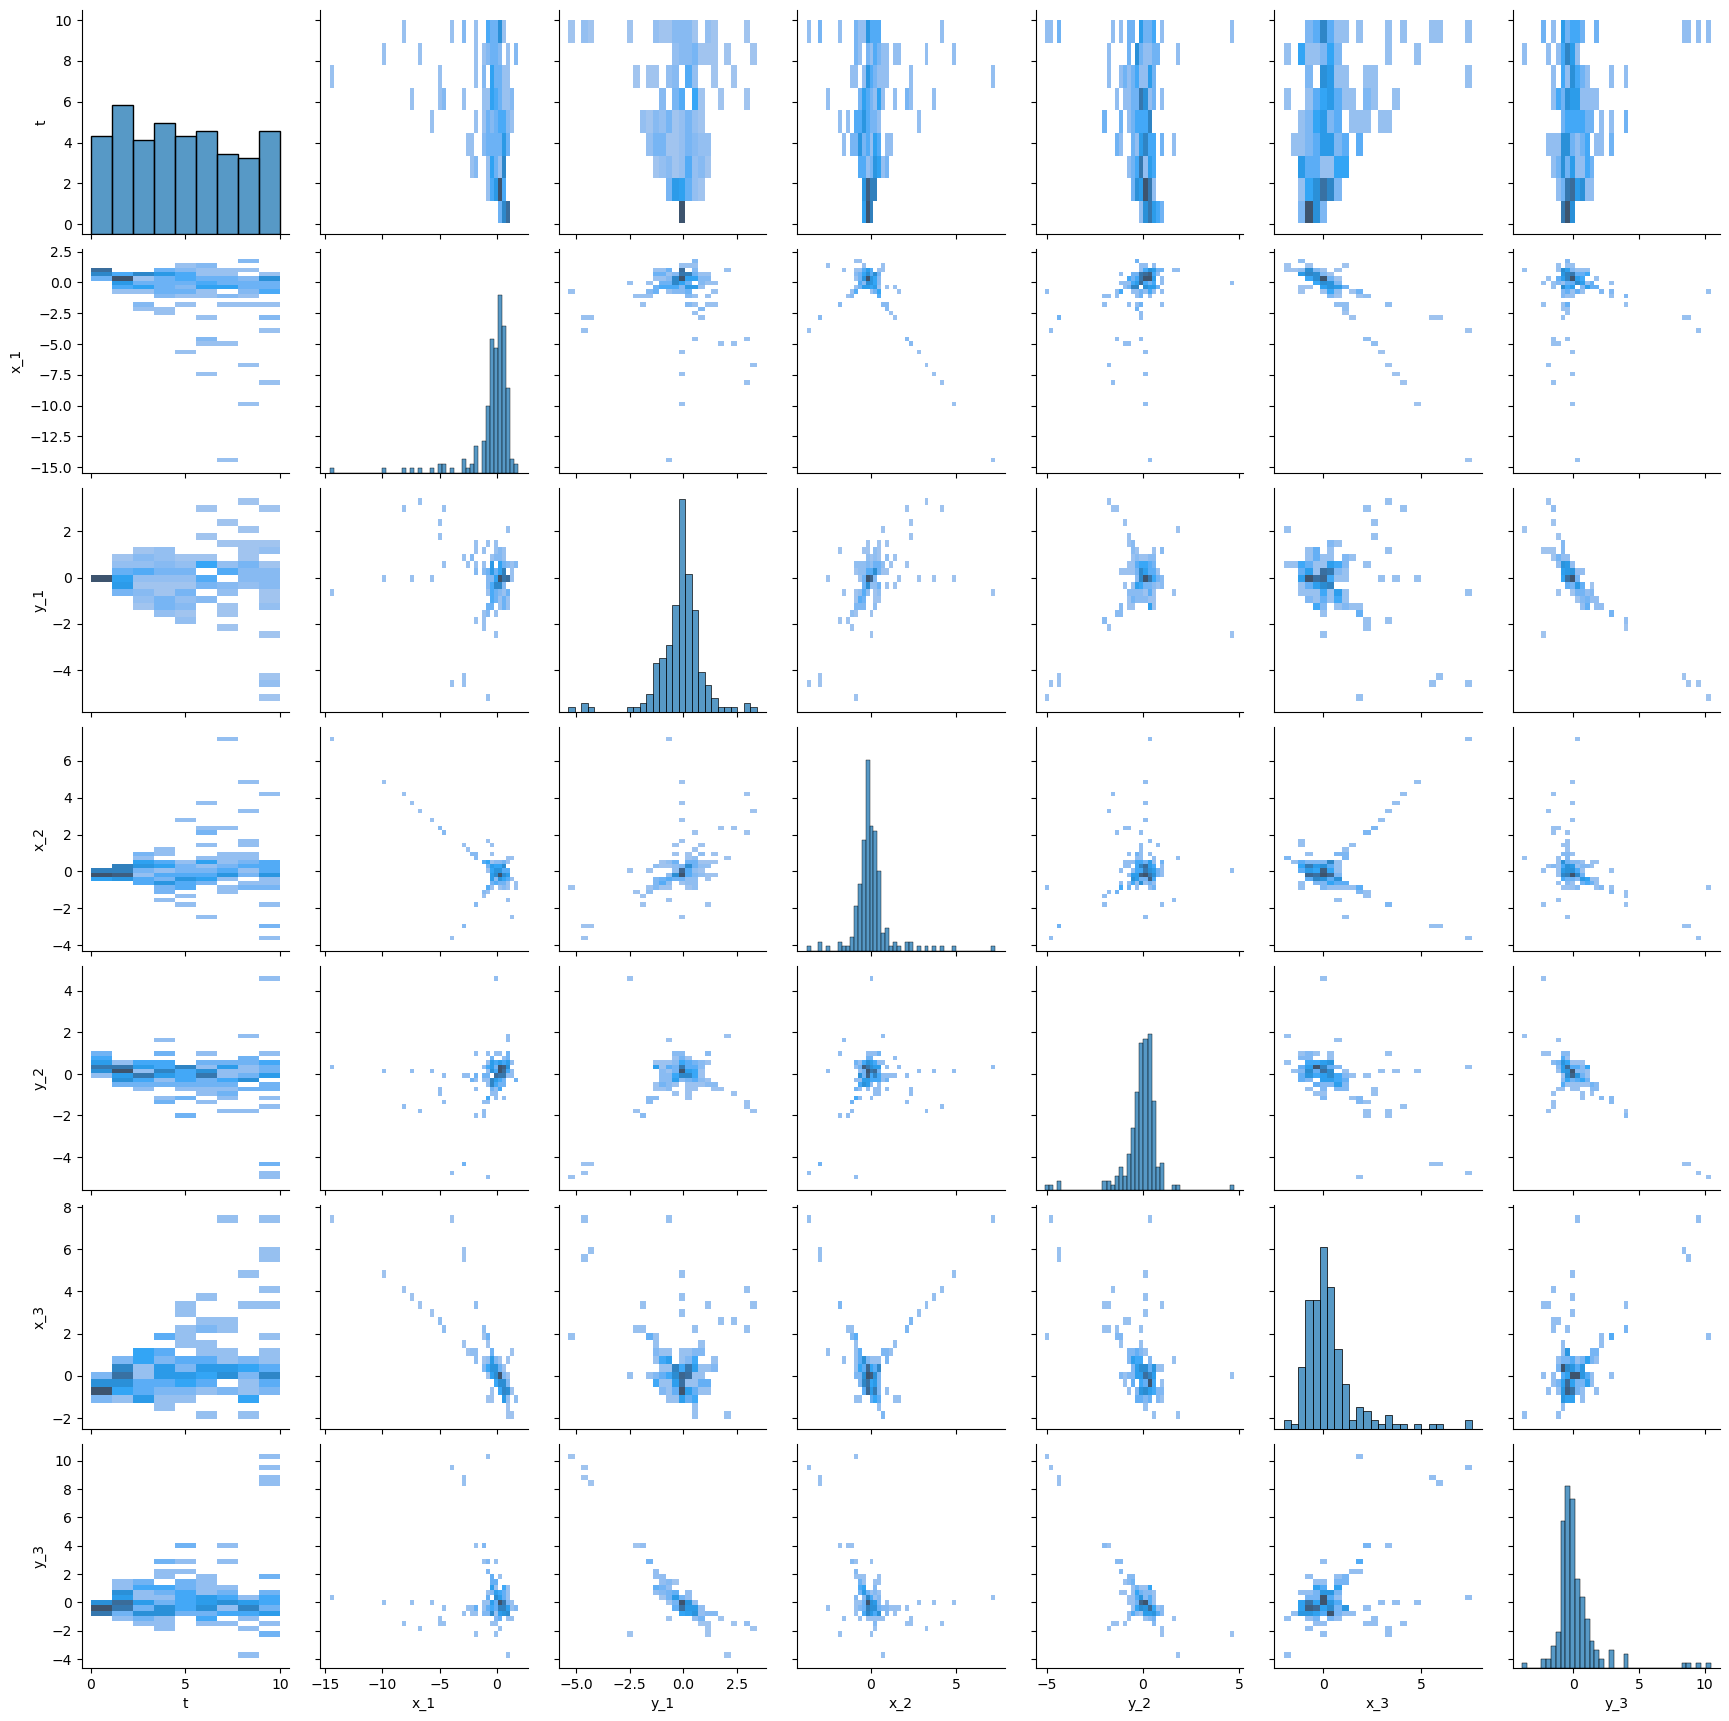

In [46]:
import seaborn as sns
sns.pairplot(new_data.sample(200), kind="hist")

<Axes: >

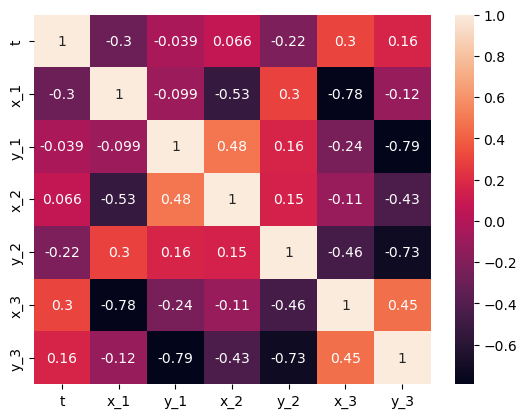

In [42]:
corr = new_data.corr()
sns.heatmap(corr,annot=True)

# Task 3.2 Evaluation of Variable Reduction

# Task 3.3 Adding Variables

# Task 3.4 Evaluation of Variable Augmentation